In [2]:
import matplotlib.pyplot as plt
plt.style.use("custom_standard")
# plt.style.use("custom_small")
import seaborn as sns
import pandas as pd
import numpy as np
from slim_conservation_scoring.pipeline import group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import slim_conservation_scoring.seqtools.general_utils as tools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def file_converter(filepath):
    return filepath.replace('/home/jch/Documents/08-benchmark/', '../../../')

# final

note that this is not very elegant but it works

inputs

In [4]:
table_file = "../../../benchmark/benchmark_v4/MSA_comparison/benchmark_table_MSA_comparison_ANNOTATED.csv"
df = pd.read_csv(table_file)
df = df[df["ELM_motif_class"] != "TRAF6"]
df = df[df["ELM_motif_class"] != "LIG_14-3-3_CanoR_1"]
df = df[
    [
        "reference_index",
        "Organism",
        "Primary_Acc",
        "Accessions",
        "UniprotID",
        "regex",
        "hit_sequence",
        "gene_id",
        "hit start position",
        "hit end position",
        "verified interaction",
        "ELM_motif_class",
        "name",
        "critical_error",
        "json_file",
    ]
]

In [5]:
df

,reference_index,Organism,Primary_Acc,Accessions,UniprotID,regex,hit_sequence,gene_id,hit start position,hit end position,verified interaction,ELM_motif_class,name,critical_error,json_file
0,0,Rattus norvegicus,O08838,O08838,O08838,DP[FW],DPF,10116_0:004cdf,356,358,True,LIG_AP2alpha_2,NaN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
1,1,Rattus norvegicus,Q05140,Q05140,Q05140,DP[FW],DPF,10116_0:002e5e,399,401,True,LIG_AP2alpha_2,NaN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
2,2,Rattus norvegicus,Q05140,Q05140,Q05140,DP[FW],DPF,10116_0:002e5e,473,475,True,LIG_AP2alpha_2,NaN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
3,3,Homo sapiens,P98082,P98082 A6NES5 Q13598 Q9BTY0 Q9UK04,P98082,DP[FW],DPF,9606_0:0016b2,292,294,True,LIG_AP2alpha_2,NaN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
4,4,Homo sapiens,P98082,P98082 A6NES5 Q13598 Q9BTY0 Q9UK04,P98082,DP[FW],DPF,9606_0:0016b2,297,299,True,LIG_AP2alpha_2,NaN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2361,Homo sapiens,NaN,NaN,Q8TF72,[FL]PPPP,FPPPP,9606_0:0012c3,1545,1549,True,enah_LPPPP_FPPPP,SHRM3_HUMAN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
306,2362,Homo sapiens,NaN,NaN,P18206,[FL]PPPP,FPPPP,9606_0:002935,841,845,True,enah_LPPPP_FPPPP,VINC_HUMAN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
307,2363,Homo sapiens,NaN,NaN,Q702N8,[FL]PPPP,LPPPP,9606_0:000f47,23,27,True,enah_LPPPP_FPPPP,XIRP1_HUMAN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...
308,2364,Homo sapiens,NaN,NaN,Q15942,[FL]PPPP,LPPPP,9606_0:001d2c,72,76,True,enah_LPPPP_FPPPP,ZYX_HUMAN,NaN,/home/jch/Documents/08-benchmark/benchmark/ben...


add position masks

In [6]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "enah_LPPPP_FPPPP": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
}
df['mask_array'] = df["ELM_motif_class"].map(position_weights)

In [7]:
SCOREKEY = "aln_shannon_entropy"
LEVELS = ["Tetrapoda", "Vertebrata", "Metazoa"]
ALLLEVELS = []
for lvl in LEVELS:
    ALLLEVELS.append(lvl)
    ALLLEVELS.append(lvl + '-Muscle')
    ALLLEVELS.append(lvl + '-clustalo')

In [8]:
def json_2_score_list(json_file, level, scorekey, filepath_converter=file_converter):
    if filepath_converter is not None:
        json_file = filepath_converter(json_file)
    og = group_tools.ConserGene(json_file, filepath_converter=filepath_converter)
    try:
        lvlo=og.get_aln_score_obj(level=level, score_key=scorekey, filepath_converter=filepath_converter)
    except KeyError:
        print(json_file)
        return
    return lvlo.hit_scores

In [9]:
for level in ALLLEVELS:
    colname = f"{level}_{SCOREKEY}_scorelist"
    df[colname] = df["json_file"].apply(
        lambda x: json_2_score_list(x, level, SCOREKEY)
    )
cols = [i for i in df.columns if "_scorelist" in i]

../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/427-9606_0_002d5f/427-9606_0_002d5f.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/435-10116_0_001079/435-10116_0_001079.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/436-10116_0_001079/436-10116_0_001079.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/437-10116_0_001079/437-10116_0_001079.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/808-9606_0_0030e7/808-9606_0_0030e7.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/809-9606_0_0030e7/809-9606_0_0030e7.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/1169-9606_0_0017ce/1169-9606_0_0017ce.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/1531-9606_0_004b09/1531-9606_0_004b09.json
../../../benchmark/benchmark_v4/MSA_comparison/conservation_analysis/1534-9606_0_0036d0/1534-9606_0_0036d0.jso

In [10]:
df[cols].isna().sum()

Tetrapoda_aln_shannon_entropy_scorelist              20
Tetrapoda-Muscle_aln_shannon_entropy_scorelist       20
Tetrapoda-clustalo_aln_shannon_entropy_scorelist     20
Vertebrata_aln_shannon_entropy_scorelist              0
Vertebrata-Muscle_aln_shannon_entropy_scorelist       0
Vertebrata-clustalo_aln_shannon_entropy_scorelist     0
Metazoa_aln_shannon_entropy_scorelist                 0
Metazoa-Muscle_aln_shannon_entropy_scorelist          0
Metazoa-clustalo_aln_shannon_entropy_scorelist        0
dtype: int64

The missing Tetrapoda scores are because the homolog groups contained less than 20 sequences <br>
We will just remove those entries entirely

In [11]:
ol = len(df)
df = df.dropna(how='any', axis=0, subset=cols).copy()
nl = len(df)
print(f'removed {ol-nl} entries from table')
print(f'{nl} remaining SLiMs')

removed 20 entries from table
240 remaining SLiMs


In [12]:
df[cols].isna().sum()

Tetrapoda_aln_shannon_entropy_scorelist              0
Tetrapoda-Muscle_aln_shannon_entropy_scorelist       0
Tetrapoda-clustalo_aln_shannon_entropy_scorelist     0
Vertebrata_aln_shannon_entropy_scorelist             0
Vertebrata-Muscle_aln_shannon_entropy_scorelist      0
Vertebrata-clustalo_aln_shannon_entropy_scorelist    0
Metazoa_aln_shannon_entropy_scorelist                0
Metazoa-Muscle_aln_shannon_entropy_scorelist         0
Metazoa-clustalo_aln_shannon_entropy_scorelist       0
dtype: int64

In [13]:
def check_list(l):
    if not isinstance(l, list):
        return False
    for i in l:
        if not isinstance(i, float):
            return False
    return True

for col in cols:
    df[f'{col}_check'] = df[col].apply(check_list)

for col in cols:
    assert (df[f'{col}_check'] == True).all(), 'there are issues with the score lists'

In [14]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

for col in cols:
    df[f'{col}_masked'] = df.apply(
        lambda x: extract_important_scores(x, col), axis=1
    )
df['hit_sequence_residues'] = df['hit_sequence'].apply(list)
df['hit_sequence_residues_masked'] = df.apply(
    lambda x: extract_important_scores(x, 'hit_sequence_residues'), axis=1
)

In [15]:
masked_cols=[f'{col}_masked' for col in cols]
# explode the list of scores into individual rows
weighted_residue_score_df = df.explode(masked_cols+['hit_sequence_residues_masked'])
# make sure it did what we expected
test = weighted_residue_score_df.loc[296]
for aa,score in zip(test["hit_sequence"].iloc[0],test["Metazoa_aln_shannon_entropy_scorelist"].iloc[0]):
    print(aa,score)
print('-----')
for aa, score in zip(test['hit_sequence_residues_masked'],test["Metazoa_aln_shannon_entropy_scorelist_masked"]):
    print(aa, score)

F 0.5167701847382201
P 0.2931283148259326
P 0.22548974420384596
P 0.2144377321672786
P 0.2241297788093233
-----
F 0.5167701847382201
P 0.2931283148259326
P 0.2144377321672786
P 0.2241297788093233


In [16]:
weighted_residue_score_df = weighted_residue_score_df[
    [
        "reference_index",
        "regex",
        "hit_sequence",
        "gene_id",
        "ELM_motif_class",
        "name",
        "json_file",
        "mask_array",
        "hit_sequence_residues_masked"
    ]
    +
    masked_cols
].copy()
weighted_residue_score_df['ELM_motif_class'] = weighted_residue_score_df['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')

In [17]:
print(len(weighted_residue_score_df))

731


In [18]:
def make_scatterplots(dfin, level, scorekey):
    colname_dict={
        f"{level}_{scorekey}_scorelist_masked": "Mafft",
        f"{level}-Muscle_{scorekey}_scorelist_masked": "Muscle",
        f"{level}-clustalo_{scorekey}_scorelist_masked": "clustalo",
    }
    filter_cols = list(colname_dict.keys())
    filter_cols.append("ELM_motif_class")
    df = dfin[filter_cols].copy()
    df=df.rename(columns=colname_dict)
    df=df.rename(columns={"ELM_motif_class": "motif"})
    fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
    sns.scatterplot(
        x="Mafft",
        y="clustalo",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[0],
    )
    sns.scatterplot(
        x="Mafft",
        y="Muscle",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[1],
    )
    sns.scatterplot(
        x="clustalo",
        y="Muscle",
        hue="motif",
        data=df,
        alpha=0.5,
        ax=axes[2],
    )
    for ax in axes:
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.tight_layout()

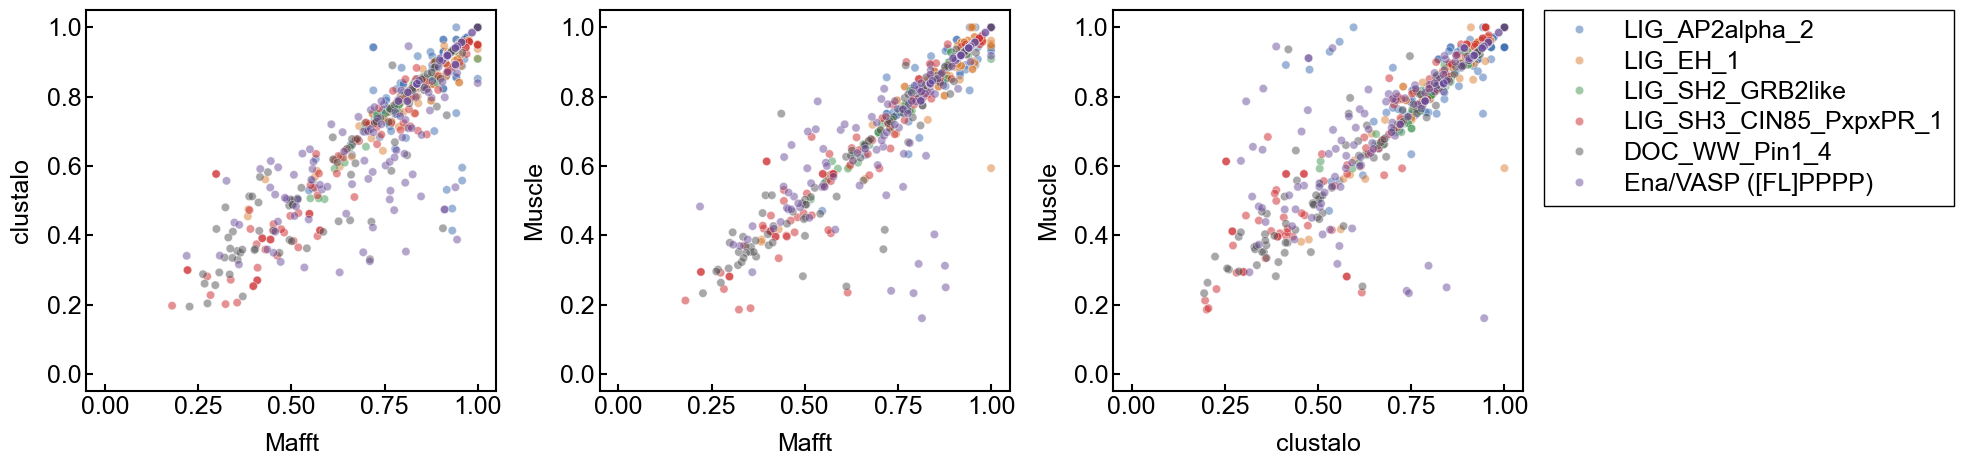

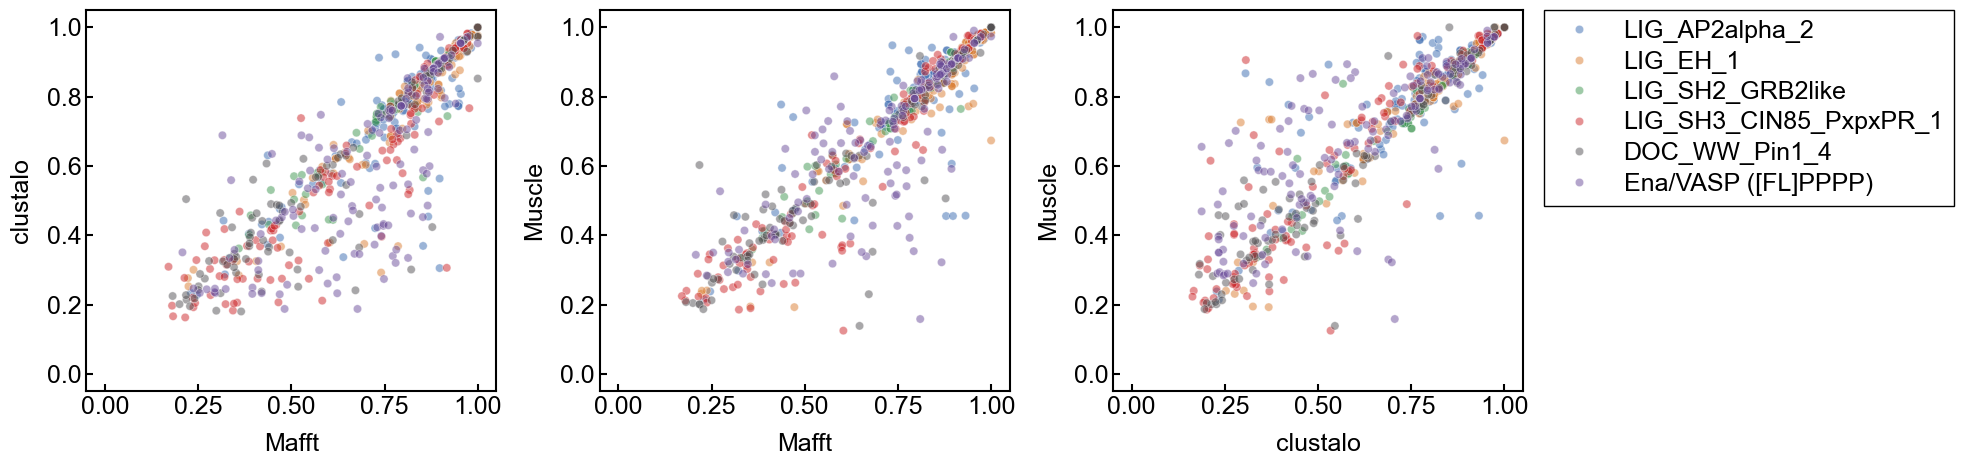

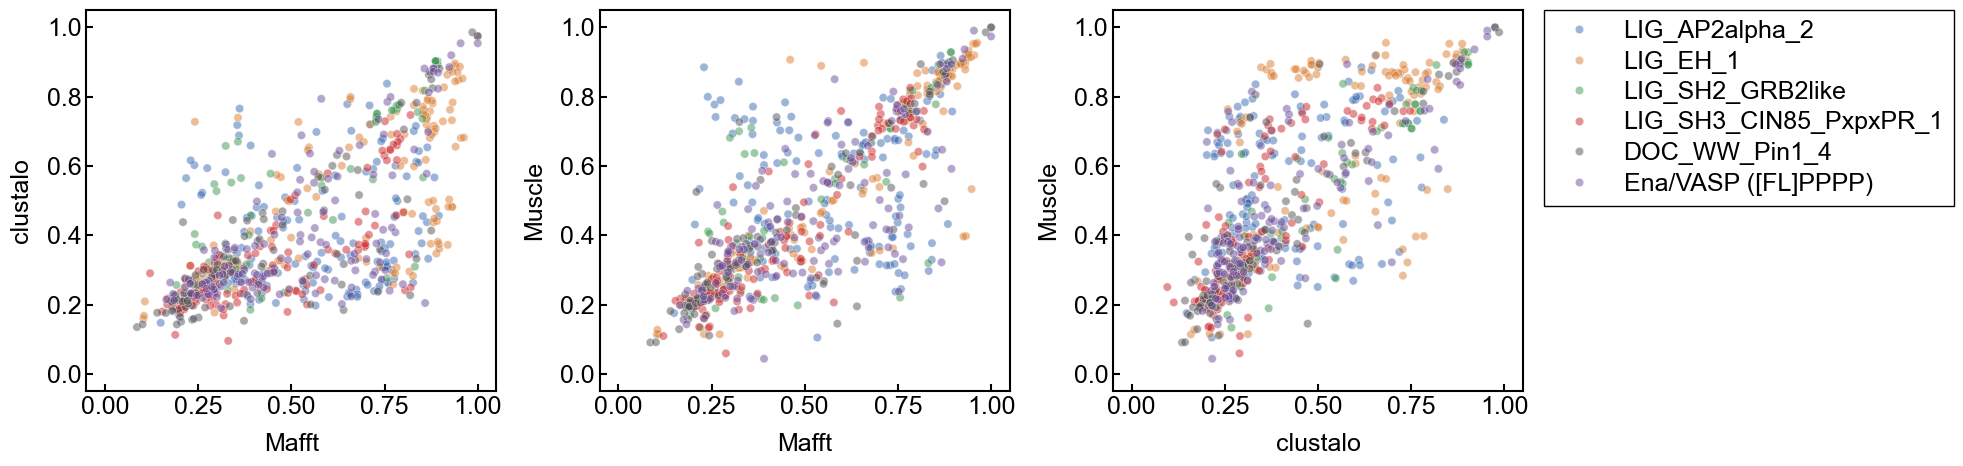

In [19]:
supp_output=Path('../../supplement/MSA_correlation_levels/')
for level in LEVELS:
    make_scatterplots(weighted_residue_score_df, level, SCOREKEY)
    plt.savefig(f"./SLiM_residue_MSA_correlation-{level}.png", dpi=400)
    plt.savefig(supp_output / f"SLiM_residue_MSA_correlation-{level}.png", dpi=400)

In [20]:
print(weighted_residue_score_df.reference_index.nunique())

240


In [21]:
print(len(weighted_residue_score_df['Metazoa_aln_shannon_entropy_scorelist_masked']))

731


---